In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

path = '/content/drive/My Drive/Colab Notebooks/Pytorch/Data'
train_data = datasets.MNIST(root=path, train=True, transform=transform, download=True)

test_data = datasets.MNIST(root=path, train=False, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/My Drive/Colab Notebooks/Pytorch/Data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/My Drive/Colab Notebooks/Pytorch/Data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/My Drive/Colab Notebooks/Pytorch/Data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/My Drive/Colab Notebooks/Pytorch/Data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/My Drive/Colab Notebooks/Pytorch/Data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/My Drive/Colab Notebooks/Pytorch/Data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/My Drive/Colab Notebooks/Pytorch/Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/My Drive/Colab Notebooks/Pytorch/Data/MNIST/raw



In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/My Drive/Colab Notebooks/Pytorch/Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/drive/My Drive/Colab Notebooks/Pytorch/Data
    Split: Test
    StandardTransform
Transform: ToTensor()

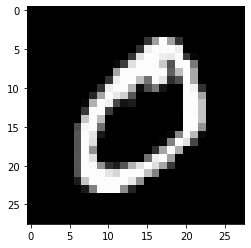

In [5]:
image, label = train_data[1]
plt.imshow(image.reshape(28,28), cmap='gray') 
# imshow is a function that allows us to display an image based on the passed array.
# The second argument is optional, and I passed it just because the built in colorscale is viriad, 
# but the original dataset is to a gray scale.

In [6]:
#Load test and training data into batches
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [11]:
#Define the model architecture

class ConvNN(nn.Module):
  def __init__(self):
    # The input layer for the first fc layer is 5*5*16 which is determined by the architecture of our network.
    # The first layer takes in a 28x28 image and the kernel removes 1 pixel from all 4 sides, leaving an image of 26x26.
    # The over all effect is ((28-2)/2 - 2)/2 = 5.5 and we round down to a finalized 5x5 image and there are 16 output channels.
    
    super().__init__()
    #1 input channel --> 6 filters (output channels) --> 3x3 kernel --> stride=1
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
   
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.out = nn.Linear(84, 10)
    
  def forward(self, x):
    '''
      4D formated images ---> Conv layer 1---> pooling layer ---> conv layer 2 --> pooling layer --> fc1 --> ... --> output layer
    '''
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2) #input, kernel size, stride

    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    # at this point, our output is a 4D array, we need to reshape it into a 2D array to be fed into the linear layers
    x = x.view(-1,16*5*5) #we use -1 so that we can vary the batch size!

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return F.log_softmax(x,dim=1)

In [15]:
#inititalize model, loss function, and optimizer
model = ConvNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [16]:
#Trainig
epochs = 5 
train_losses = []
test_losses = []

for i in range(epochs):
 #training
  for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
     
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%2000 == 0:
          print(f'EPOCH: {i+1}  BATCH: {b}  LOSS: {loss.item()}')

  train_losses.append(loss)

 #testing
  with torch.no_grad():
    for X_test, y_test in test_loader:
      y_val = model(X_test)

    loss = criterion(y_val, y_test)
    test_losses.append(loss)

EPOCH: 1  BATCH: 2000  LOSS: 0.0053147547878324986
EPOCH: 1  BATCH: 4000  LOSS: 0.050641488283872604
EPOCH: 1  BATCH: 6000  LOSS: 0.007401148788630962
EPOCH: 2  BATCH: 2000  LOSS: 0.0012685699621215463
EPOCH: 2  BATCH: 4000  LOSS: 0.000529178767465055
EPOCH: 2  BATCH: 6000  LOSS: 0.06797831505537033
EPOCH: 3  BATCH: 2000  LOSS: 0.0010031454730778933
EPOCH: 3  BATCH: 4000  LOSS: 4.984971019439399e-05
EPOCH: 3  BATCH: 6000  LOSS: 0.0009449162753298879
EPOCH: 4  BATCH: 2000  LOSS: 0.1306435614824295
EPOCH: 4  BATCH: 4000  LOSS: 0.02373814396560192
EPOCH: 4  BATCH: 6000  LOSS: 0.00011764953524107113
EPOCH: 5  BATCH: 2000  LOSS: 0.00019623551634140313
EPOCH: 5  BATCH: 4000  LOSS: 0.0030328978318721056
EPOCH: 5  BATCH: 6000  LOSS: 6.592226418433711e-05


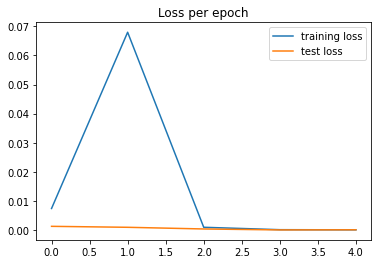

In [17]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.title('Loss per epoch')
plt.legend();

In [18]:
#Testing with brand new data
all_test_data = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
  correct = 0
  for x_test, y_test in all_test_data:
    y_val = model(x_test)
    actual_prediction = torch.max(y_val, 1)[1]
    correct += (actual_prediction == y_test).sum()

accuracy = correct.item()/len(test_data)

In [19]:
print(f'The total accuracy for this batch is {accuracy*100}%')

The total accuracy for this batch is 98.46000000000001%


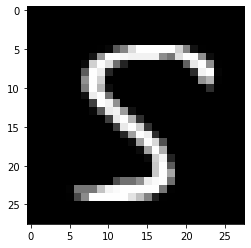

In [20]:
image, label = test_data[333]
plt.imshow(image.reshape(28,28), cmap='gray') 

In [21]:
guess = model(image.view(1,1,28,28))
guess = torch.max(guess,1)[1].item()

print(f'The model predicted {guess} and the expected value was {label}!')

The model predicted 5 and the expected value was 5!


In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

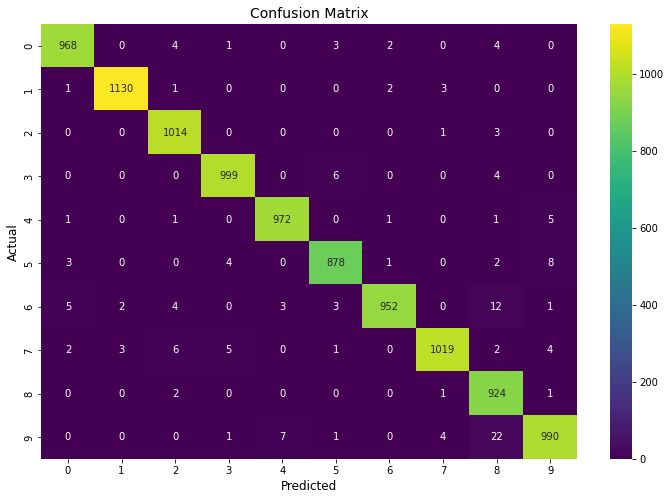

In [37]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_matrix(actual_prediction, y_test), annot=True, cmap='viridis',fmt='d');
plt.title('Confusion Matrix', size=14);
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12)
plt.savefig('CNN_confusion_matrix.pdf', dpi=300);